# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print( '%s: ' % k, v.shape)

X_val:  (1000, 3, 32, 32)
y_test:  (1000,)
y_val:  (1000,)
y_train:  (49000,)
X_test:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `cs231n/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, cache = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

assert out.shape == (x.shape[0], w.shape[0], int(1 + (x.shape[2] + 2 * conv_param['pad'] - w.shape[2]) / conv_param['stride']), \
                     int(1 + (x.shape[3] + 2 * conv_param['pad'] - w.shape[3]) / conv_param['stride']))
assert out.shape == correct_out.shape

# Compare your output to ours; difference should be around 1e-8
print( 'Testing conv_forward_naive')
print( 'difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

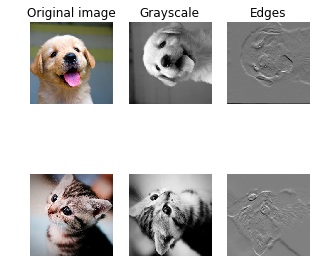

In [4]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 *(img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

def single_color_image(im, color=0):
    if im.ndim != 3:
        raise ValueError("Invalid input image. Expected a numpy array with dim 3 (bgr).")
    if color < 0 or color > 3:
        raise ValueError("Color should be 0,1,2 (red, green, blue)")
    return im[color,:,:]

def single_channel_image(im, color=0):
    if im.ndim != 3:
        raise ValueError("Invalid input image. Expected a numpy array with dim 3 (bgr).")
    if color < 0 or color > 3:
        raise ValueError("Color should be 0,1,2 (red, green, blue)")
    channel_reduced = np.zeros(im.shape)
    channel_reduced[color,:,:] = single_color_image(im, color)
    #return the image back in the same 3-dim format
    return channel_reduced

# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, int(d/2):-int(d/2), :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 1, 0))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 1, 0))
#


# plt.figure()
# imshow_noax(imresize(puppy, (img_size, img_size)))
# plt.figure()
# imshow_noax(imresize(kitten_cropped, (img_size, img_size)))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

plt.figure(figsize=(5,5))
# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [5]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

assert dx.shape   == dx_num.shape
assert dw.shape   == dw_num.shape
assert db.shape   == db_num.shape
assert dout.shape == out.shape

# Your errors should be around 1e-9'
print( 'Testing conv_backward_naive function')
print( 'dx error: ', rel_error(dx, dx_num))
print( 'dw error: ', rel_error(dw, dw_num))
print( 'db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.0940976828e-09
dw error:  5.09227834456e-10
db error:  1.31007646878e-11


# Max pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [6]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])


assert out.shape == correct_out.shape

# Compare your output with ours. Difference should be around 1e-8.
print( 'Testing max_pool_forward_naive function:')
print( 'difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


# Max pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [7]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

assert dx_num.shape == dx.shape
assert out.shape == dout.shape

# Your error should be around 1e-12
print( 'Testing max_pool_backward_naive function:')
print(np.linalg.norm(dx - dx_num) / (np.linalg.norm(dx) + np.linalg.norm(dx_num)))
print( 'dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
3.32332647955e-12
dx error:  1.89288997704e-11


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [8]:
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print( 'Testing conv_forward_fast:')
print( 'Naive: %fs' % (t1 - t0))
print( 'Fast: %fs' % (t2 - t1))
print( 'Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print( 'Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print( '\nTesting conv_backward_fast:')
print( 'Naive: %fs' % (t1 - t0))
print( 'Fast: %fs' % (t2 - t1))
print( 'Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print( 'dx difference: ', rel_error(dx_naive, dx_fast))
print( 'dw difference: ', rel_error(dw_naive, dw_fast))
print( 'db difference: ', rel_error(db_naive, db_fast))

assert out_naive.shape == out_fast.shape
assert dx_naive.shape == dx_fast.shape
assert dw_naive.shape == dw_fast.shape
assert db_naive.shape == db_fast.shape
assert dout.shape == out_fast.shape


Testing conv_forward_fast:
Naive: 10.805531s
Fast: 0.031230s
Speedup: 345.998725x
Difference:  6.67531474073e-11

Testing conv_backward_fast:
Naive: 15.337036s
Fast: 0.027822s
Speedup: 551.260058x
dx difference:  6.08157484129e-12
dw difference:  2.25474780641e-12
db difference:  5.37183283739e-14


In [9]:
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print( 'Testing pool_forward_fast:')
print( 'Naive: %fs' % (t1 - t0))
print( 'fast: %fs' % (t2 - t1))
print( 'speedup: %fx' % ((t1 - t0) / (t2 - t1 + 1e-16)))
print( 'difference: ', rel_error(out_naive, out_fast))
print(np.linalg.norm(out_naive - out_fast)/(np.linalg.norm(out_naive) + np.linalg.norm(out_fast)))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print( '\nTesting pool_backward_fast:')
print( 'Naive: %fs' % (t1 - t0))
print( 'speedup: %fx' % ((t1 - t0) / (t2 - t1 + 1e-16)))
print( 'dx difference: ', rel_error(dx_naive, dx_fast))

assert out_naive.shape == out_fast.shape
assert dx_naive.shape == dx_fast.shape
assert dw_naive.shape == dw_fast.shape
assert db_naive.shape == db_fast.shape
assert dout.shape     == out_fast.shape


Testing pool_forward_fast:
Naive: 0.887934s
fast: 0.015628s
speedup: 56.816488x
difference:  0.0
0.0

Testing pool_backward_fast:
Naive: 2.629321s
speedup: 84.134416x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [10]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print( 'Testing conv_relu_pool')
print( 'dx error: ', rel_error(dx_num, dx))
print( 'dw error: ', rel_error(dw_num, dw))
print( 'db error: ', rel_error(db_num, db))

assert dx_num.shape == dx.shape
assert dw_num.shape == dw.shape
assert db_num.shape == db.shape

Testing conv_relu_pool
dx error:  1.6786263969e-08
dw error:  3.93048693905e-09
db error:  9.43128545807e-11


In [11]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print( 'Testing conv_relu:')
print( 'dx error: ', rel_error(dx_num, dx))
print( 'dw error: ', rel_error(dw_num, dw))
print( 'db error: ', rel_error(db_num, db))

#NEED to check shape

Testing conv_relu:
dx error:  5.84819670459e-09
dw error:  1.79386524737e-10
db error:  3.30845450623e-12


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [12]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print( 'Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print( 'Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.30269477938
Initial loss (with regularization):  2.50863004912


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [13]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=50,
                          dtype=np.float64)

loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-5)
    
    e = rel_error(param_grad_num.reshape(grads[param_name].shape), grads[param_name])
    print( '%s max relative error: %e' % (param_name, e))

W1 max relative error: 9.180817e-01
W2 max relative error: 1.333416e-03
W3 max relative error: 6.438864e-06
b1 max relative error: 7.538660e-07
b2 max relative error: 1.000000e+00
b3 max relative error: 1.334708e-10


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [14]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=5e-3)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 40) loss: 2.304739
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.119000
(Iteration 2 / 40) loss: 2.435137
(Epoch 1 / 20) train acc: 0.170000; val_acc: 0.121000
(Iteration 3 / 40) loss: 2.307968
(Iteration 4 / 40) loss: 2.123895
(Epoch 2 / 20) train acc: 0.310000; val_acc: 0.123000
(Iteration 5 / 40) loss: 2.112765
(Iteration 6 / 40) loss: 2.044538
(Epoch 3 / 20) train acc: 0.350000; val_acc: 0.171000
(Iteration 7 / 40) loss: 1.859159
(Iteration 8 / 40) loss: 1.709323
(Epoch 4 / 20) train acc: 0.400000; val_acc: 0.173000
(Iteration 9 / 40) loss: 1.631874
(Iteration 10 / 40) loss: 1.351791
(Epoch 5 / 20) train acc: 0.480000; val_acc: 0.174000
(Iteration 11 / 40) loss: 1.473159
(Iteration 12 / 40) loss: 1.195224
(Epoch 6 / 20) train acc: 0.620000; val_acc: 0.213000
(Iteration 13 / 40) loss: 0.990619
(Iteration 14 / 40) loss: 1.192923
(Epoch 7 / 20) train acc: 0.640000; val_acc: 0.217000
(Iteration 15 / 40) loss: 0.959266
(Iteration 16 / 40) loss: 0.624632
(Epoch 8 / 20) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

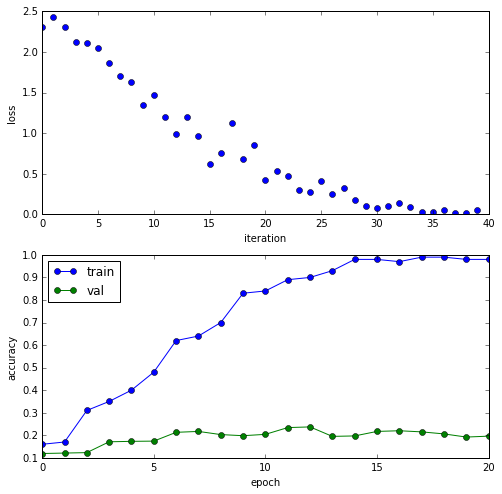

In [15]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

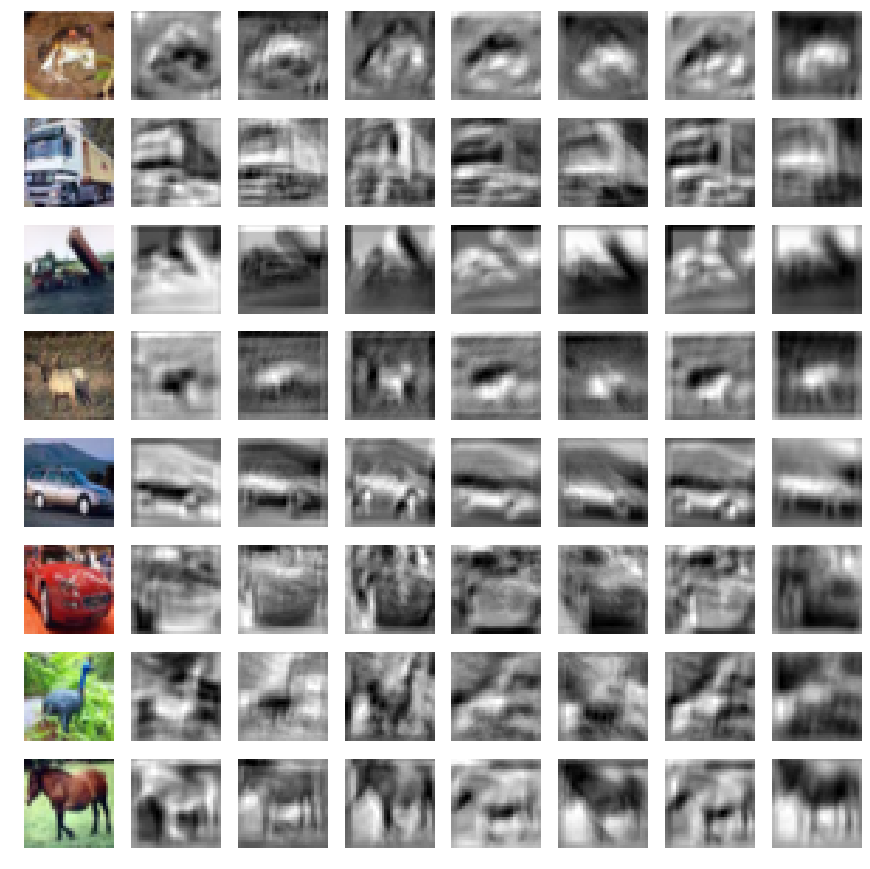

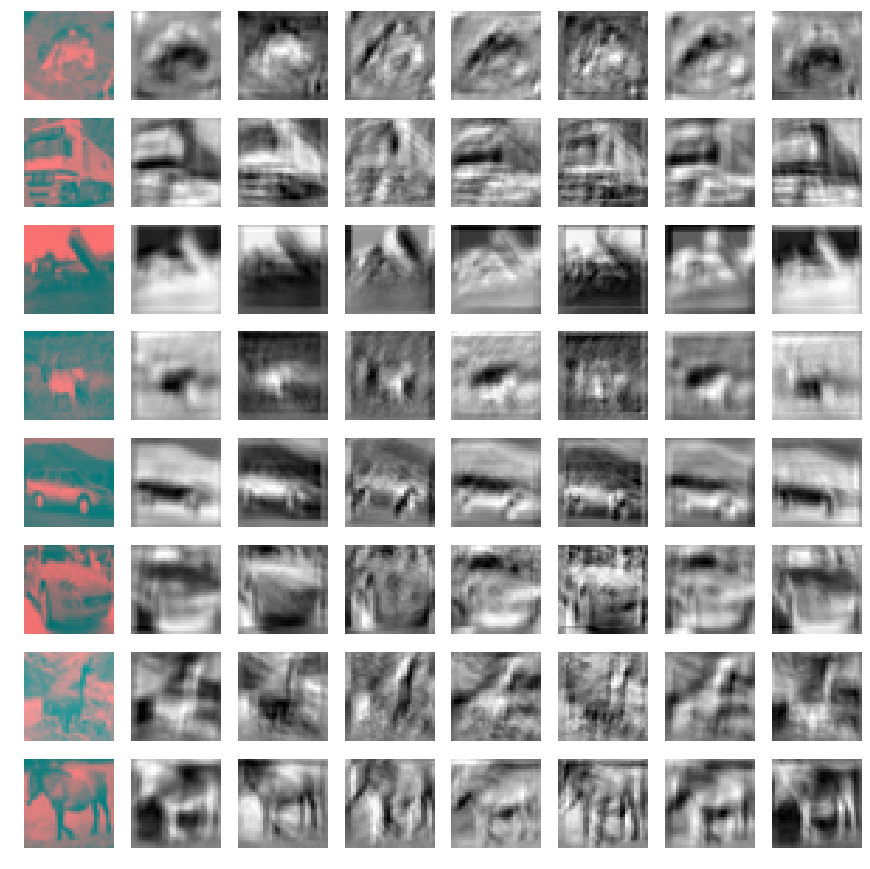

In [16]:
##
#  PLOTTING THE WEIGHTS.
##

W1 = model.params['W1']
b1 = model.params['b1']
out, _ = conv_forward_naive(data['X_train'][0:8], W1, b1, {'stride': 1, 'pad': 3})
#shape 3,32,32 -> 1,28,28
# have 32 filters so end up with 32x28x28

red_image = []
for x in data['X_train'][0:8]:
    red_image.append(single_channel_image(x))
#     plt.figure(figsize=(1.5,1.5))
#     imshow_noax(red_image[-1].transpose(1,2,0))
#     plt.figure(figsize=(1.5,1.5))
#     imshow_noax(x.transpose(1,2,0))

red_image = np.array(red_image)

out_r, _ = conv_forward_naive(red_image[0:8], W1, b1, {'stride': 1, 'pad': 3})

fig = plt.figure(figsize=(15,15))
#go over 'n samples'

for idx,x in enumerate(data['X_train'][0:8]):
    fig.add_subplot(8,8, 8*idx + 1)
    imshow_noax(x.transpose(1,2,0))
    fig.add_subplot(8,8, 8*idx + 2)
    imshow_noax(out[idx][0])
    fig.add_subplot(8,8, 8*idx + 3)
    imshow_noax(out[idx][1])
    fig.add_subplot(8,8, 8*idx + 4)
    imshow_noax(out[idx][2])
    fig.add_subplot(8,8, 8*idx + 5)
    imshow_noax(out[idx][3])
    fig.add_subplot(8,8, 8*idx + 6)
    imshow_noax(out[idx][4])
    fig.add_subplot(8,8, 8*idx + 7)
    imshow_noax(out[idx][5])
    fig.add_subplot(8,8, 8*idx + 8)
    imshow_noax(out[idx][6])

fig = plt.figure(figsize=(15,15))
for idx,x in enumerate(red_image):
    fig.add_subplot(8,8, 8*idx + 1)
    imshow_noax(x.transpose(1,2,0))
    fig.add_subplot(8,8, 8*idx + 2)
    imshow_noax(out_r[idx][0])
    fig.add_subplot(8,8, 8*idx + 3)
    imshow_noax(out_r[idx][1])
    fig.add_subplot(8,8, 8*idx + 4)
    imshow_noax(out_r[idx][2])
    fig.add_subplot(8,8, 8*idx + 5)
    imshow_noax(out_r[idx][3])
    fig.add_subplot(8,8, 8*idx + 6)
    imshow_noax(out_r[idx][4])
    fig.add_subplot(8,8, 8*idx + 7)
    imshow_noax(out_r[idx][5])
    fig.add_subplot(8,8, 8*idx + 8)
    imshow_noax(out_r[idx][6])


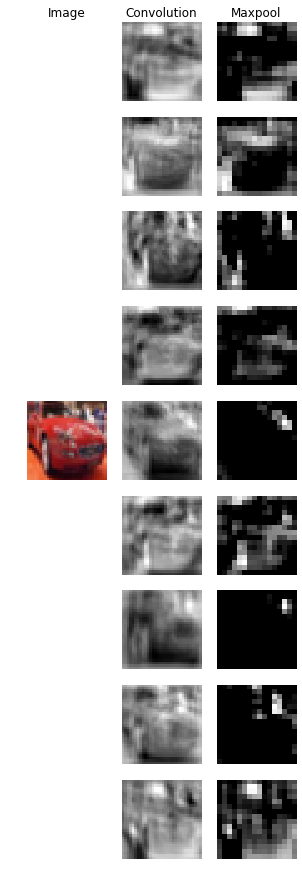

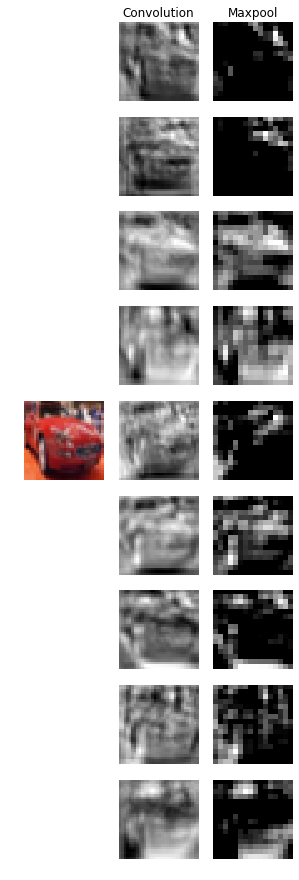

In [17]:
##
#  PLOTTING THE LAYER OUTPUT for a test image.
##

W1 = model.params['W1']
b1 = model.params['b1']
out, _ = conv_forward_naive(data['X_train'][0:8], W1, b1, {'stride': 1, 'pad': 3})
out_2, _ = conv_relu_pool_forward(data['X_train'][0:8], W1, b1, 
                                  {'stride': 1, 'pad': 3}, 
                                  {'pool_height': 2, 'pool_width': 2, 'stride': 2})

#shape 3,32,32 -> 1,28,28
# have 32 filters so end up with 32x28x28

fig = plt.figure(figsize=(15,15))
#go over 'n samples'

x_input = data['X_train']
fig.add_subplot(9,9,1)
plt.title("Image")
plt.gca().axis('off')
fig.add_subplot(9,9,4*9+1)
imshow_noax(x_input[5].transpose(1,2,0))

for idx in range(0,9):
    fig.add_subplot(9,9, 9*idx + 2)
    imshow_noax(out[5][idx])
    if idx == 0:
        plt.title("Convolution")
    fig.add_subplot(9,9, 9*idx + 3)
    imshow_noax(out_2[5][idx])
    if idx == 0:
        plt.title("Maxpool")
        
fig = plt.figure(figsize=(15,15))
x_input = data['X_train']
fig.add_subplot(9,9,4*9+1)
imshow_noax(x_input[5].transpose(1,2,0))

for idx in range(0,9):
    fig.add_subplot(9,9, 9*idx + 2)
    imshow_noax(out[5][idx+9])
    if idx == 0:
        plt.title("Convolution")
    fig.add_subplot(9,9, 9*idx + 3)
    imshow_noax(out_2[5][idx+9])
    if idx == 0:
        plt.title("Maxpool")

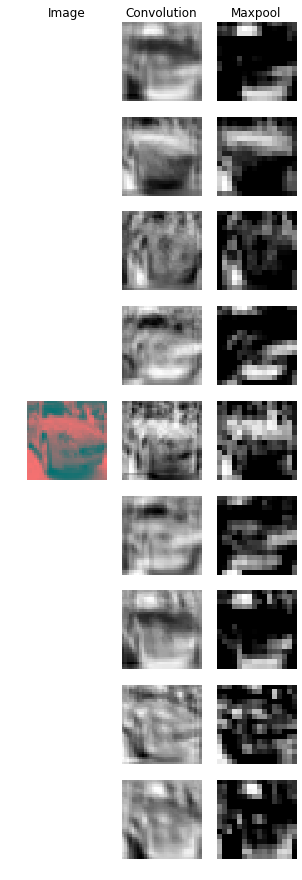

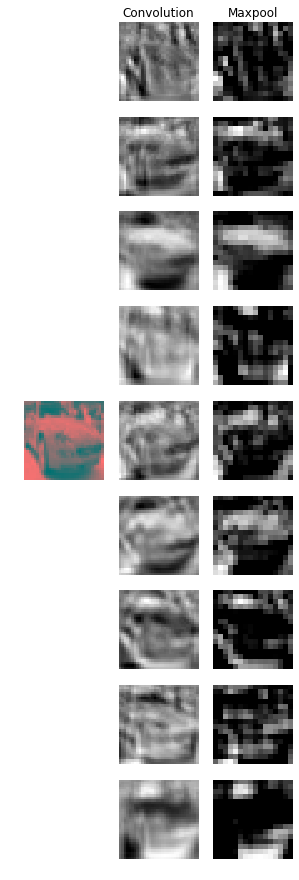

In [18]:
##
#  PLOTTING THE LAYER OUTPUT for a test image.
##

W1 = model.params['W1']
b1 = model.params['b1']

red_image = []
for x in data['X_train'][0:8]:
    red_image.append(single_channel_image(x))
#     plt.figure(figsize=(1.5,1.5))
#     imshow_noax(red_image[-1].transpose(1,2,0))
#     plt.figure(figsize=(1.5,1.5))
#     imshow_noax(x.transpose(1,2,0))

red_image = np.array(red_image)

out, _ = conv_forward_naive(red_image[0:8], W1, b1, {'stride': 1, 'pad': 3})
out_2, _ = conv_relu_pool_forward(red_image[0:8], W1, b1, 
                                  {'stride': 1, 'pad': 3}, 
                                  {'pool_height': 2, 'pool_width': 2, 'stride': 2})

#shape 3,32,32 -> 1,28,28
# have 32 filters so end up with 32x28x28

fig = plt.figure(figsize=(15,15))
#go over 'n samples'

fig.add_subplot(9,9,1)
plt.title("Image")
plt.gca().axis('off')
fig.add_subplot(9,9,4*9+1)
imshow_noax(red_image[5].transpose(1,2,0))

for idx in range(0,9):
    fig.add_subplot(9,9, 9*idx + 2)
    imshow_noax(out[5][idx])
    if idx == 0:
        plt.title("Convolution")
    fig.add_subplot(9,9, 9*idx + 3)
    imshow_noax(out_2[5][idx])
    if idx == 0:
        plt.title("Maxpool")
        
fig = plt.figure(figsize=(15,15))
fig.add_subplot(9,9,4*9+1)
imshow_noax(red_image[5].transpose(1,2,0))

for idx in range(0,9):
    fig.add_subplot(9,9, 9*idx + 2)
    imshow_noax(out[5][idx+9])
    if idx == 0:
        plt.title("Convolution")
    fig.add_subplot(9,9, 9*idx + 3)
    imshow_noax(out_2[5][idx+9])
    if idx == 0:
        plt.title("Maxpool")

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [19]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=50, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.302737
(Epoch 0 / 1) train acc: 0.104000; val_acc: 0.113000
(Iteration 21 / 980) loss: 2.273054
(Iteration 41 / 980) loss: 2.058474
(Iteration 61 / 980) loss: 2.092582
(Iteration 81 / 980) loss: 1.901714
(Iteration 101 / 980) loss: 1.855255
(Iteration 121 / 980) loss: 1.897698
(Iteration 141 / 980) loss: 1.783753
(Iteration 161 / 980) loss: 1.678423
(Iteration 181 / 980) loss: 1.819102
(Iteration 201 / 980) loss: 1.721795
(Iteration 221 / 980) loss: 1.761036
(Iteration 241 / 980) loss: 1.727217
(Iteration 261 / 980) loss: 1.495970
(Iteration 281 / 980) loss: 1.645993
(Iteration 301 / 980) loss: 1.780056
(Iteration 321 / 980) loss: 1.880318
(Iteration 341 / 980) loss: 1.353932
(Iteration 361 / 980) loss: 1.527840
(Iteration 381 / 980) loss: 1.492905
(Iteration 401 / 980) loss: 1.493541
(Iteration 421 / 980) loss: 1.544467
(Iteration 441 / 980) loss: 1.481506
(Iteration 461 / 980) loss: 1.477942
(Iteration 481 / 980) loss: 1.577013
(Iteration 501 / 980) loss: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

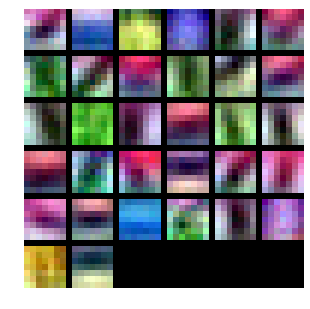

In [20]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

## Spatial batch normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [21]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print( 'Before spatial batch normalization:')
print( '  Shape: ', x.shape)
print( '  Means: ', x.mean(axis=(0, 2, 3)))
print( '  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print( 'After spatial batch normalization:')
print( '  Shape: ', out.shape)
print( '  Means: ', out.mean(axis=(0, 2, 3)))
print( '  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print( 'After spatial batch normalization (nontrivial gamma, beta):')
print( '  Shape: ', out.shape)
print( '  Means: ', out.mean(axis=(0, 2, 3)))
print( '  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 11.30345737  10.866294     9.22283352]
  Stds:  [ 3.7503687   4.03456678  4.11088122]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ -1.66533454e-16   4.44089210e-16  -1.77635684e-16]
  Stds:  [ 0.99999964  0.99999969  0.9999997 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.99999893  3.99999877  4.99999852]


In [22]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
    x = 2.3 * np.random.randn(N, C, H, W) + 13
    spatial_batchnorm_forward(x, gamma, beta, bn_param)

bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print( 'After spatial batch normalization (test-time):')
print( '  means: ', a_norm.mean(axis=(0, 2, 3)))
print( '  stds: ', a_norm.std(axis=(0, 2, 3)))


After spatial batch normalization (test-time):
  means:  [ 0.01674885 -0.01990482  0.03510996  0.01167015]
  stds:  [ 1.00052761  0.97526244  0.9983296   1.02791858]


## Spatial batch normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [23]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)

for i in range(dgamma.shape[0]):
    print(np.linalg.norm(dx), np.linalg.norm(dx_num))
    print(dgamma[i], da_num[i])
    print(dbeta[i], db_num[i])

print( 'dx error: ',     rel_error(dx_num, dx))
print( 'dgamma error: ', rel_error(da_num, dgamma))
print( 'dbeta error: ',  rel_error(db_num, dbeta))

2.00260693111 2.00260693103
1.35162710366 1.35162710371
5.27672598087 5.27672598084
2.00260693111 2.00260693103
-5.2478110301 -5.24781103009
-0.46682344335 -0.466823443369
2.00260693111 2.00260693103
0.411435029771 0.411435029777
0.638878835068 0.638878835063
dx error:  2.95135901342e-08
dgamma error:  1.67173268444e-11
dbeta error:  2.00581635796e-11


In [ ]:
from matplotlib import animation

In [25]:
from cs231n.classifiers.convnets import *

deeper_model = ConvNet()

solver = Solver(deeper_model, data,
                num_epochs=10, batch_size=500,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=10)
solver.train()

(Iteration 1 / 980) loss: 2.302631
(Epoch 0 / 10) train acc: 0.075000; val_acc: 0.107000
(Iteration 11 / 980) loss: 2.164335
(Iteration 21 / 980) loss: 1.978753
(Iteration 31 / 980) loss: 1.904677
(Iteration 41 / 980) loss: 1.925084
(Iteration 51 / 980) loss: 1.758502
(Iteration 61 / 980) loss: 1.666508
(Iteration 71 / 980) loss: 1.603037
(Iteration 81 / 980) loss: 1.568220
(Iteration 91 / 980) loss: 1.552741
(Epoch 1 / 10) train acc: 0.479000; val_acc: 0.496000
(Iteration 101 / 980) loss: 1.454646
(Iteration 111 / 980) loss: 1.435013
(Iteration 121 / 980) loss: 1.437139
(Iteration 131 / 980) loss: 1.360768
(Iteration 141 / 980) loss: 1.357588
(Iteration 151 / 980) loss: 1.270345
(Iteration 161 / 980) loss: 1.338969
(Iteration 171 / 980) loss: 1.267759
(Iteration 181 / 980) loss: 1.352030
(Iteration 191 / 980) loss: 1.272363
(Epoch 2 / 10) train acc: 0.565000; val_acc: 0.554000
(Iteration 201 / 980) loss: 1.234545
(Iteration 211 / 980) loss: 1.128094
(Iteration 221 / 980) loss: 1.26562

In [26]:
solver.num_epochs = 10
solver.batch_size = 500
solver.optim_config['learning_rate'] = 1e-4
solver.train()

(Iteration 1 / 980) loss: 0.545919
(Epoch 10 / 10) train acc: 0.829000; val_acc: 0.642000
(Iteration 11 / 980) loss: 0.474653
(Iteration 21 / 980) loss: 0.534706
(Iteration 31 / 980) loss: 0.489821
(Iteration 41 / 980) loss: 0.493850
(Iteration 51 / 980) loss: 0.379342
(Iteration 61 / 980) loss: 0.460196
(Iteration 71 / 980) loss: 0.559309
(Iteration 81 / 980) loss: 0.497459
(Iteration 91 / 980) loss: 0.467012
(Epoch 11 / 10) train acc: 0.856000; val_acc: 0.627000
(Iteration 101 / 980) loss: 0.436509
(Iteration 111 / 980) loss: 0.490565
(Iteration 121 / 980) loss: 0.456742
(Iteration 131 / 980) loss: 0.482427
(Iteration 141 / 980) loss: 0.458783
(Iteration 151 / 980) loss: 0.406290
(Iteration 161 / 980) loss: 0.441692
(Iteration 171 / 980) loss: 0.449370
(Iteration 181 / 980) loss: 0.421437
(Iteration 191 / 980) loss: 0.393117
(Epoch 12 / 10) train acc: 0.874000; val_acc: 0.618000
(Iteration 201 / 980) loss: 0.376180
(Iteration 211 / 980) loss: 0.461942
(Iteration 221 / 980) loss: 0.44

In [27]:
deeper_model_1 = ConvNet(weight_scale=1e-2)
deeper_model_1.params['W1'] = np.copy(deeper_model.params['W1'])
deeper_model_1.params['b1'] = np.copy(deeper_model.params['b1'])

solver = Solver(deeper_model_1, data,
                num_epochs=5, batch_size=500,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=10)
solver.train()

(Iteration 1 / 490) loss: 2.352656
(Epoch 0 / 5) train acc: 0.098000; val_acc: 0.102000
(Iteration 11 / 490) loss: 2.057041
(Iteration 21 / 490) loss: 1.788763
(Iteration 31 / 490) loss: 1.596645
(Iteration 41 / 490) loss: 1.520020
(Iteration 51 / 490) loss: 1.426306
(Iteration 61 / 490) loss: 1.370559
(Iteration 71 / 490) loss: 1.326460
(Iteration 81 / 490) loss: 1.265464
(Iteration 91 / 490) loss: 1.307021
(Epoch 1 / 5) train acc: 0.572000; val_acc: 0.558000
(Iteration 101 / 490) loss: 1.144562
(Iteration 111 / 490) loss: 1.239021
(Iteration 121 / 490) loss: 1.136835
(Iteration 131 / 490) loss: 1.043940
(Iteration 141 / 490) loss: 1.205682
(Iteration 151 / 490) loss: 1.022148
(Iteration 161 / 490) loss: 0.958537
(Iteration 171 / 490) loss: 1.055690
(Iteration 181 / 490) loss: 1.071730
(Iteration 191 / 490) loss: 1.027160
(Epoch 2 / 5) train acc: 0.646000; val_acc: 0.613000
(Iteration 201 / 490) loss: 1.150938
(Iteration 211 / 490) loss: 1.021768
(Iteration 221 / 490) loss: 1.185717
(

In [28]:
solver.num_epochs = 5
solver.batch_size = 200
solver.optim_config['learning_rate'] = 1e-4
solver.train()

(Iteration 1 / 1225) loss: 0.741813
(Epoch 5 / 5) train acc: 0.703000; val_acc: 0.648000
(Iteration 11 / 1225) loss: 0.815574
(Iteration 21 / 1225) loss: 0.792353
(Iteration 31 / 1225) loss: 0.821691
(Iteration 41 / 1225) loss: 0.831221
(Iteration 51 / 1225) loss: 0.913199
(Iteration 61 / 1225) loss: 0.913804
(Iteration 71 / 1225) loss: 1.025190
(Iteration 81 / 1225) loss: 0.943683
(Iteration 91 / 1225) loss: 0.912863
(Iteration 101 / 1225) loss: 0.880900
(Iteration 111 / 1225) loss: 1.051443
(Iteration 121 / 1225) loss: 1.010123
(Iteration 131 / 1225) loss: 0.936292
(Iteration 141 / 1225) loss: 0.915341
(Iteration 151 / 1225) loss: 0.750571
(Iteration 161 / 1225) loss: 0.915951
(Iteration 171 / 1225) loss: 0.932426
(Iteration 181 / 1225) loss: 0.843255
(Iteration 191 / 1225) loss: 0.922025
(Iteration 201 / 1225) loss: 1.033267
(Iteration 211 / 1225) loss: 0.817158
(Iteration 221 / 1225) loss: 0.894601
(Iteration 231 / 1225) loss: 0.812480
(Iteration 241 / 1225) loss: 0.638600
(Epoch 6

In [29]:
# solver.num_epochs = 5
# solver.batch_size = 200
# solver.optim_config['learning_rate'] = 1e-5
# solver.train()

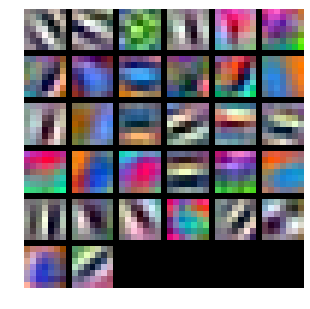

In [30]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(deeper_model_1.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

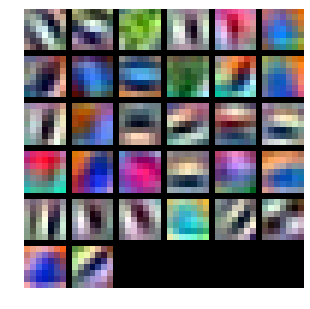

In [31]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(deeper_model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

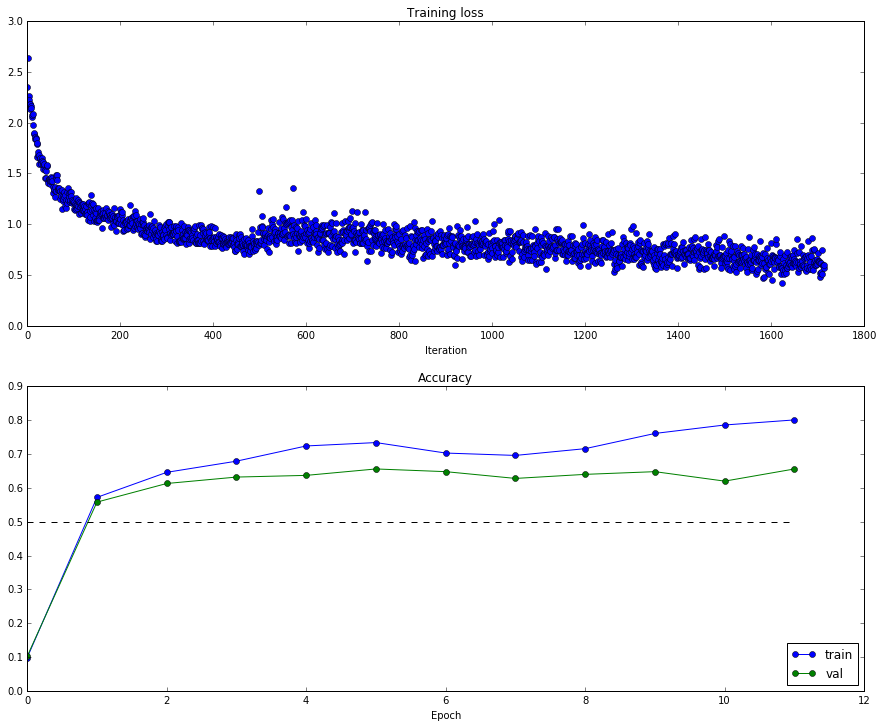

In [32]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [37]:
from cs231n.classifiers.convnets import ConvNet_dropout

deeper_model_drop_out = ConvNet_dropout(num_filters=[64,128],filter_size=[3,3],dropout=0.5)

solver_drop_out = Solver(deeper_model_drop_out, data,
                num_epochs=10, batch_size=200,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=10)
solver_drop_out.train()

(Iteration 1 / 2450) loss: 2.302609
(Epoch 0 / 10) train acc: 0.106000; val_acc: 0.102000
(Iteration 11 / 2450) loss: 2.104313
(Iteration 21 / 2450) loss: 2.069004
(Iteration 31 / 2450) loss: 2.096500
(Iteration 41 / 2450) loss: 1.998618
(Iteration 51 / 2450) loss: 1.888874
(Iteration 61 / 2450) loss: 1.811815
(Iteration 71 / 2450) loss: 1.870061
(Iteration 81 / 2450) loss: 1.787267
(Iteration 91 / 2450) loss: 1.667701
(Iteration 101 / 2450) loss: 1.715915
(Iteration 111 / 2450) loss: 1.622630
(Iteration 121 / 2450) loss: 1.640279
(Iteration 131 / 2450) loss: 1.593895
(Iteration 141 / 2450) loss: 1.546830
(Iteration 151 / 2450) loss: 1.692809
(Iteration 161 / 2450) loss: 1.596113
(Iteration 171 / 2450) loss: 1.504453
(Iteration 181 / 2450) loss: 1.549070
(Iteration 191 / 2450) loss: 1.544705
(Iteration 201 / 2450) loss: 1.543164
(Iteration 211 / 2450) loss: 1.685994
(Iteration 221 / 2450) loss: 1.557747
(Iteration 231 / 2450) loss: 1.475816
(Iteration 241 / 2450) loss: 1.513670
(Epoch 

In [38]:
solver_drop_out.num_epochs = 2
solver_drop_out.batch_size = 300
solver_drop_out.optim_config['learning_rate'] = 1e-4
solver_drop_out.train()

(Iteration 1 / 326) loss: 1.048646
(Epoch 10 / 2) train acc: 0.611000; val_acc: 0.588000
(Iteration 11 / 326) loss: 1.093431
(Iteration 21 / 326) loss: 1.091511
(Iteration 31 / 326) loss: 1.068525
(Iteration 41 / 326) loss: 1.050720
(Iteration 51 / 326) loss: 0.965152
(Iteration 61 / 326) loss: 1.045985
(Iteration 71 / 326) loss: 1.064968
(Iteration 81 / 326) loss: 1.073717
(Iteration 91 / 326) loss: 1.027361
(Iteration 101 / 326) loss: 0.928683
(Iteration 111 / 326) loss: 1.053070
(Iteration 121 / 326) loss: 0.951120
(Iteration 131 / 326) loss: 1.027479
(Iteration 141 / 326) loss: 0.977797
(Iteration 151 / 326) loss: 0.910864
(Iteration 161 / 326) loss: 0.918541
(Epoch 11 / 2) train acc: 0.639000; val_acc: 0.615000
(Iteration 171 / 326) loss: 0.987681
(Iteration 181 / 326) loss: 0.941376
(Iteration 191 / 326) loss: 1.120805
(Iteration 201 / 326) loss: 1.027571
(Iteration 211 / 326) loss: 0.987384
(Iteration 221 / 326) loss: 0.908596
(Iteration 231 / 326) loss: 0.999821
(Iteration 241 

In [39]:
#deeper_model_drop_out.dropout_param['seed'] = np.random.randint(10000)

solver_drop_out.num_epochs = 4
solver_drop_out.batch_size = 300
solver_drop_out.optim_config['learning_rate'] = 1e-5
solver_drop_out.train()

(Iteration 1 / 652) loss: 1.000523
(Epoch 12 / 4) train acc: 0.671000; val_acc: 0.618000
(Iteration 11 / 652) loss: 0.937973
(Iteration 21 / 652) loss: 1.016547
(Iteration 31 / 652) loss: 1.046101
(Iteration 41 / 652) loss: 1.023753
(Iteration 51 / 652) loss: 1.004358
(Iteration 61 / 652) loss: 0.974448
(Iteration 71 / 652) loss: 1.065805
(Iteration 81 / 652) loss: 1.037578
(Iteration 91 / 652) loss: 0.894084
(Iteration 101 / 652) loss: 0.851613
(Iteration 111 / 652) loss: 0.894622
(Iteration 121 / 652) loss: 0.962532
(Iteration 131 / 652) loss: 0.992665
(Iteration 141 / 652) loss: 1.050962
(Iteration 151 / 652) loss: 0.924471
(Iteration 161 / 652) loss: 1.011238
(Epoch 13 / 4) train acc: 0.666000; val_acc: 0.605000
(Iteration 171 / 652) loss: 1.000264
(Iteration 181 / 652) loss: 0.870720
(Iteration 191 / 652) loss: 0.994723
(Iteration 201 / 652) loss: 0.893893
(Iteration 211 / 652) loss: 0.907053
(Iteration 221 / 652) loss: 1.002106
(Iteration 231 / 652) loss: 1.112813
(Iteration 241 

In [40]:
solver_drop_out.num_epochs = 8
solver_drop_out.batch_size = 300
solver_drop_out.optim_config['learning_rate'] = 1e-5
solver_drop_out.train()

(Iteration 1 / 1304) loss: 0.992475
(Epoch 16 / 8) train acc: 0.658000; val_acc: 0.599000
(Iteration 11 / 1304) loss: 0.914441
(Iteration 21 / 1304) loss: 1.012039
(Iteration 31 / 1304) loss: 1.013809
(Iteration 41 / 1304) loss: 0.928521
(Iteration 51 / 1304) loss: 0.916385
(Iteration 61 / 1304) loss: 1.203036
(Iteration 71 / 1304) loss: 1.038324
(Iteration 81 / 1304) loss: 1.004204
(Iteration 91 / 1304) loss: 1.013448
(Iteration 101 / 1304) loss: 0.886989
(Iteration 111 / 1304) loss: 1.082986
(Iteration 121 / 1304) loss: 0.957582
(Iteration 131 / 1304) loss: 0.999236
(Iteration 141 / 1304) loss: 0.965650
(Iteration 151 / 1304) loss: 0.901947
(Iteration 161 / 1304) loss: 0.965813
(Epoch 17 / 8) train acc: 0.658000; val_acc: 0.606000
(Iteration 171 / 1304) loss: 0.890626
(Iteration 181 / 1304) loss: 1.121893
(Iteration 191 / 1304) loss: 0.918213
(Iteration 201 / 1304) loss: 1.074586
(Iteration 211 / 1304) loss: 0.984940
(Iteration 221 / 1304) loss: 0.834921
(Iteration 231 / 1304) loss: 

In [41]:
print(np.mean(deeper_model_drop_out.params['W1']))
print(np.mean(deeper_model.params['W1']))

0.000275217
-0.000323134


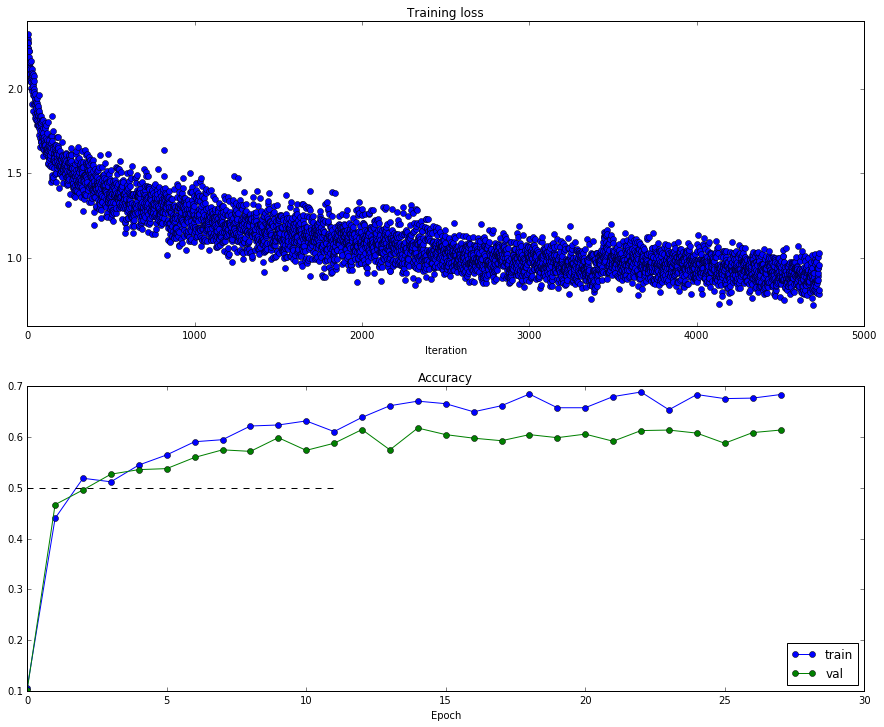

In [42]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver_drop_out.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver_drop_out.train_acc_history, '-o', label='train')
plt.plot(solver_drop_out.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

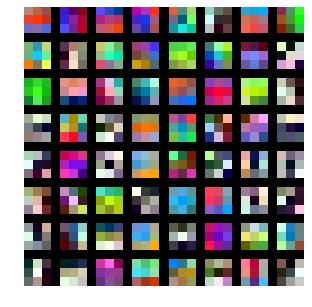

In [43]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(deeper_model_drop_out.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

In [44]:
best_model = deeper_model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.642
Test set accuracy:  0.64


In [45]:
best_model = deeper_model_drop_out
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.603
Test set accuracy:  0.588


# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization aafter affine layers. Do your networks train faster?
- Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [46]:
# Train a really good model on CIFAR-10

In [47]:
#(1) should try and build VGG Net (or something like it)
#(2) try and implement ResNET
#ResNet input_layer -> CNN -> CNN -> output
#            |                         ^
#            |                         |
#            ---------shaping--------- +
# input_layer -> out1, out2
# output_layer (in1,in2) return (in1 + lambda * in2, in1 + lambda * in2)
# NOTE: have to copy numpy arrays at every output.
#

# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

In [48]:
y_test_pred = np.argmax(deeper_model_1.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(deeper_model_1.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.656
Test set accuracy:  0.633


(3, 32, 32)
plane
--------
Precision =  0.62
Recalll   =  0.6019417475728155
car
--------
Precision =  0.6923076923076923
Recalll   =  0.7078651685393258
bird
--------
Precision =  0.53125
Recalll   =  0.51
cat
--------
Precision =  0.47674418604651164
Recalll   =  0.39805825242718446
deer
--------
Precision =  0.5104166666666666
Recalll   =  0.5444444444444444
dog
--------
Precision =  0.5061728395061729
Recalll   =  0.47674418604651164
frog
--------
Precision =  0.7543859649122807
Recalll   =  0.7678571428571429
horse
--------
Precision =  0.7029702970297029
Recalll   =  0.696078431372549
ship
--------
Precision =  0.7068965517241379
Recalll   =  0.7735849056603774
truck
--------
Precision =  0.7310924369747899
Recalll   =  0.7981651376146789


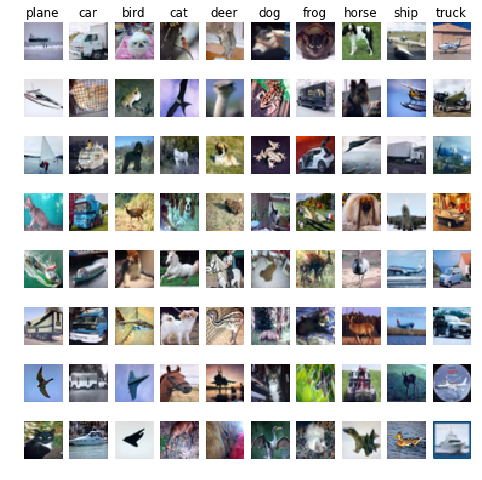

In [49]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

y_test_pred = np.argmax(deeper_model_1.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(deeper_model_1.loss(data['X_val']), axis=1)

examples_per_class = 8
y_test = data['y_test']
X_test = data['X_test']
print(X_test[0].shape)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    print(cls_name)
    print('--------')
    #precision = true positives(class_{i}) / (true positives + false positives)
    #recall    = true positives(class_{i}) / (true positives + false negatives)
    true_postives  = np.where((data['y_test'] == cls) & (y_test_pred == cls))[0]
    true_negatives = np.where((data['y_test'] != cls) & (y_test_pred != cls))[0]
    
    false_positives = np.where((data['y_test'] != cls) & (y_test_pred == cls))[0]
    false_negatives = np.where((data['y_test'] == cls) & (y_test_pred != cls))[0]
    
    print("Precision = ", len(true_postives) / (len(true_postives) + len(false_positives)))
    print("Recalll   = ", len(true_postives) / (len(true_postives) + len(false_negatives)))
    print('========')
    samples = min(examples_per_class, len(idxs))
    idxs = np.random.choice(idxs, samples, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        imshow_noax(X_test[idx].transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

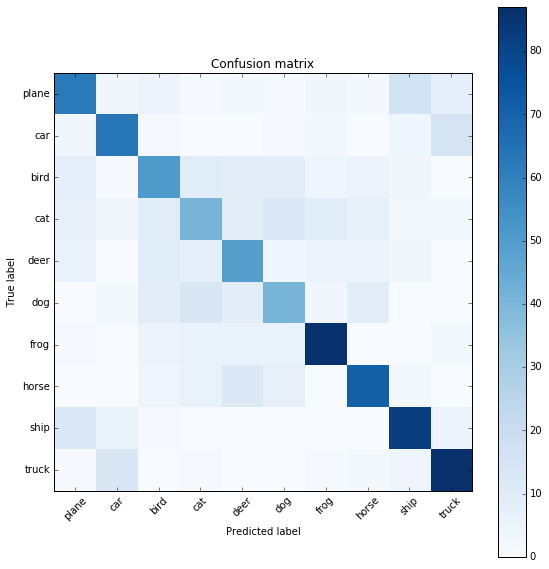

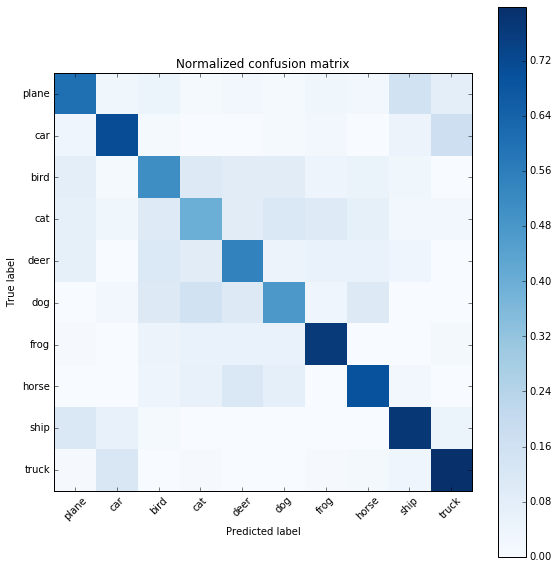

In [50]:
from sklearn.metrics import confusion_matrix

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    if labels is None:
        labels = list(range(len(cm)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, labels=classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title="Normalized confusion matrix", labels=classes)

In [51]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for cls in range(len(classes)):
    print('-----------')
    print(classes[cls])
    print('-----------')
    
    print("True Negatives  = ", len(np.where((y_test != cls) & (y_test_pred != cls))[0]),end="\t")
    print("False Negatives = ", len(np.where((y_test != cls) & (y_test_pred == cls))[0]))
    print("False Positives = ", len(np.where((y_test == cls) & (y_test_pred != cls))[0]),end="\t")
    print("True Positives  = ", len(np.where((y_test == cls) & (y_test_pred == cls))[0]))

-----------
plane
-----------
True Negatives  =  859	False Negatives =  38
False Positives =  41	True Positives  =  62
-----------
car
-----------
True Negatives  =  883	False Negatives =  28
False Positives =  26	True Positives  =  63
-----------
bird
-----------
True Negatives  =  855	False Negatives =  45
False Positives =  49	True Positives  =  51
-----------
cat
-----------
True Negatives  =  852	False Negatives =  45
False Positives =  62	True Positives  =  41
-----------
deer
-----------
True Negatives  =  863	False Negatives =  47
False Positives =  41	True Positives  =  49
-----------
dog
-----------
True Negatives  =  874	False Negatives =  40
False Positives =  45	True Positives  =  41
-----------
frog
-----------
True Negatives  =  860	False Negatives =  28
False Positives =  26	True Positives  =  86
-----------
horse
-----------
True Negatives  =  868	False Negatives =  30
False Positives =  31	True Positives  =  71
-----------
ship
-----------
True Negatives  =  860	False